# Volatility Smile and Heston Model Calibration
[Goutham Balaraman](http://gouthamanbalaraman.com)

European options on an equity underlying such as an index (S&P 500) or a stock (AMZN) trade for different combinations of strikes and maturities. It turns out that the Black-Scholes implied volatility for these options with different maturities and strikes is not the same. The fact that the implied volatility varies with strike is often referred in the market as having a *smile*.

In [1]:
import QuantLib as ql
import math

First let us define some of the basic data conventions such as the day_count, calendar etc.

In [2]:
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()

calculation_date = ql.Date(6, 11, 2015)

spot = 659.37
ql.Settings.instance().evaluationDate = calculation_date

dividend_yield = ql.QuoteHandle(ql.SimpleQuote(0.0))
risk_free_rate = 0.01
dividend_rate = 0.0
flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count))
dividend_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count))

Following is a sample matrix of volatility quote by exipiry and strike. The volatilities are log-normal volatilities and can be interpolated to construct the implied volatility surface.

In [3]:
expiration_dates = [ql.Date(6,12,2015), ql.Date(6,1,2016), ql.Date(6,2,2016),
                    ql.Date(6,3,2016), ql.Date(6,4,2016), ql.Date(6,5,2016), 
                    ql.Date(6,6,2016), ql.Date(6,7,2016), ql.Date(6,8,2016),
                    ql.Date(6,9,2016), ql.Date(6,10,2016), ql.Date(6,11,2016), 
                    ql.Date(6,12,2016), ql.Date(6,1,2017), ql.Date(6,2,2017),
                    ql.Date(6,3,2017), ql.Date(6,4,2017), ql.Date(6,5,2017), 
                    ql.Date(6,6,2017), ql.Date(6,7,2017), ql.Date(6,8,2017),
                    ql.Date(6,9,2017), ql.Date(6,10,2017), ql.Date(6,11,2017)]
strikes = [527.50, 560.46, 593.43, 626.40, 659.37, 692.34, 725.31, 758.28]
data = [
[0.37819, 0.34177, 0.30394, 0.27832, 0.26453, 0.25916, 0.25941, 0.26127],
[0.3445, 0.31769, 0.2933, 0.27614, 0.26575, 0.25729, 0.25228, 0.25202],
[0.37419, 0.35372, 0.33729, 0.32492, 0.31601, 0.30883, 0.30036, 0.29568],
[0.37498, 0.35847, 0.34475, 0.33399, 0.32715, 0.31943, 0.31098, 0.30506],
[0.35941, 0.34516, 0.33296, 0.32275, 0.31867, 0.30969, 0.30239, 0.29631],
[0.35521, 0.34242, 0.33154, 0.3219, 0.31948, 0.31096, 0.30424, 0.2984],
[0.35442, 0.34267, 0.33288, 0.32374, 0.32245, 0.31474, 0.30838, 0.30283],
[0.35384, 0.34286, 0.33386, 0.32507, 0.3246, 0.31745, 0.31135, 0.306],
[0.35338, 0.343, 0.33464, 0.32614, 0.3263, 0.31961, 0.31371, 0.30852],
[0.35301, 0.34312, 0.33526, 0.32698, 0.32766, 0.32132, 0.31558, 0.31052],
[0.35272, 0.34322, 0.33574, 0.32765, 0.32873, 0.32267, 0.31705, 0.31209],
[0.35246, 0.3433, 0.33617, 0.32822, 0.32965, 0.32383, 0.31831, 0.31344],
[0.35226, 0.34336, 0.33651, 0.32869, 0.3304, 0.32477, 0.31934, 0.31453],
[0.35207, 0.34342, 0.33681, 0.32911, 0.33106, 0.32561, 0.32025, 0.3155],
[0.35171, 0.34327, 0.33679, 0.32931, 0.3319, 0.32665, 0.32139, 0.31675],
[0.35128, 0.343, 0.33658, 0.32937, 0.33276, 0.32769, 0.32255, 0.31802],
[0.35086, 0.34274, 0.33637, 0.32943, 0.3336, 0.32872, 0.32368, 0.31927],
[0.35049, 0.34252, 0.33618, 0.32948, 0.33432, 0.32959, 0.32465, 0.32034],
[0.35016, 0.34231, 0.33602, 0.32953, 0.33498, 0.3304, 0.32554, 0.32132],
[0.34986, 0.34213, 0.33587, 0.32957, 0.33556, 0.3311, 0.32631, 0.32217],
[0.34959, 0.34196, 0.33573, 0.32961, 0.3361, 0.33176, 0.32704, 0.32296],
[0.34934, 0.34181, 0.33561, 0.32964, 0.33658, 0.33235, 0.32769, 0.32368],
[0.34912, 0.34167, 0.3355, 0.32967, 0.33701, 0.33288, 0.32827, 0.32432],
[0.34891, 0.34154, 0.33539, 0.3297, 0.33742, 0.33337, 0.32881, 0.32492]]

## Implied Volatility Surface

Each row in `data` is a different exipiration time, and each column corresponds to various strikes as given in `strikes`. We load all this data into the `QuantLib` `Matrix` object. This can then be used seamlessly in the various surface construction routines. The variable `implied_vols` holds the above data in a `Matrix` format. One unusual bit of info that one needs to pay attention to is the ordering of the rows and columns in the `Matrix` object. The implied volatilities in the `QuantLib` context needs to have strikes along the row dimension and expiries in the column dimension. This is transpose of the way the data was constructed above. All of this detail is taken care by swapping the `i` and `j` variables below. Pay attention to the line:

    implied_vols[i][j] = data[j][i]

in the cell below.

In [4]:

implied_vols = ql.Matrix(len(strikes), len(expiration_dates))
for i in range(implied_vols.rows()):
    for j in range(implied_vols.columns()):
        implied_vols[i][j] = data[j][i]

Now the Black volatility surface can be constructed using the `BlackVarianceSurface` method.

In [5]:
black_var_surface = ql.BlackVarianceSurface(
    calculation_date, calendar, 
    expiration_dates, strikes, 
    implied_vols, day_count)

The volatilities for any given strike and expiry pair can be easily obtained using `black_var_surface` shown below.

In [6]:
strike = 600.0
expiry = 1.2 # years
black_var_surface.blackVol(expiry, strike)

0.3352982638587421

## Visualization

In [7]:
import numpy as np
#% matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

Given an expiry, we can visualize the volatility as a function of the strike.

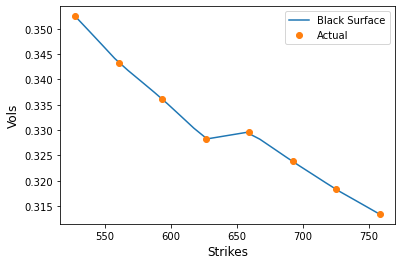

In [8]:
strikes_grid = np.arange(strikes[0], strikes[-1],10)
expiry = 1.0 # years
implied_vols = [black_var_surface.blackVol(expiry, s) 
                for s in strikes_grid] # can interpolate here
actual_data = data[11] # cherry picked the data for given expiry

fig, ax = plt.subplots()
ax.plot(strikes_grid, implied_vols, label="Black Surface")
ax.plot(strikes, actual_data, "o", label="Actual")
ax.set_xlabel("Strikes", size=12)
ax.set_ylabel("Vols", size=12)
legend = ax.legend(loc="upper right")


The whole volatility surface can also be visualised as shown below.

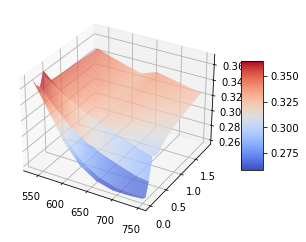

In [9]:
plot_years = np.arange(0, 2, 0.1)
plot_strikes = np.arange(535, 750, 1)
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(plot_strikes, plot_years)

'''
for xr, yr in zip(X, Y):
    for x, y in zip(xr,yr):
        print("ty is ", type(x), type(y))
        

'''
              
                  

Z = np.array([black_var_surface.blackVol(y, float(x)) 
              for xr, yr in zip(X, Y) 
                  for x, y in zip(xr,yr) ]
             ).reshape(len(X), len(X[0]))

surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, cmap=cm.coolwarm, 
                linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)


One can also construct a local volatility surface (*a la* Dupire) using the `LocalVolSurface`. There are some issues with this as shown below.

In [10]:
local_vol_surface = ql.LocalVolSurface(
    ql.BlackVolTermStructureHandle(black_var_surface), 
    flat_ts, 
    dividend_ts, 
    spot)

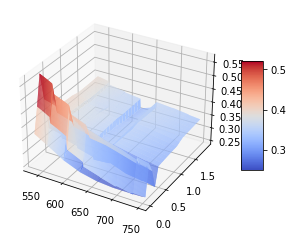

In [11]:
plot_years = np.arange(0, 2, 0.1)
plot_strikes = np.arange(535, 750, 1)
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(plot_strikes, plot_years)
Z = np.array([local_vol_surface.localVol(y, float(x)) 
              for xr, yr in zip(X, Y) 
                  for x, y in zip(xr,yr) ]
             ).reshape(len(X), len(X[0]))

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, 
                linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)

The correct pricing of local volatility surface requires an arbitrage free implied volatility surface. If the input implied volatility surface is not arbitrage free, this can lead to negative transition probabilities and/or negative local volatilities and can give rise to mispricing. Refer to Fengler's arbtirage free smoothing [1] which QuantLib currently lacks.

When you use an arbitrary smoothing, you will notice that the local volatility surface leads to undesired negative volatilities.

RuntimeError: negative local vol^2 at strike 655 and time 0.75; the black vol surface is not smooth enough

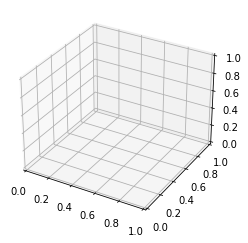

In [12]:
black_var_surface.setInterpolation("bicubic")
local_vol_surface = ql.LocalVolSurface(
    ql.BlackVolTermStructureHandle(black_var_surface), 
    flat_ts, 
    dividend_ts, 
    spot)
plot_years = np.arange(0, 2, 0.15)
plot_strikes = np.arange(535, 750, 10)
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(plot_strikes, plot_years)
Z = np.array([local_vol_surface.localVol(y, float(x)) 
              for xr, yr in zip(X, Y) 
                  for x, y in zip(xr,yr) ]
             ).reshape(len(X), len(X[0]))

surf = ax.plot_surface(Y,X, Z, rstride=1, cstride=1, cmap=cm.coolwarm, 
                linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)

## Heston Model Calibration

Heston model is defined by the following stochastic differential equations. 

\begin{eqnarray}
        dS(t, S)  &=& \mu S dt + \sqrt{v} S dW_1 \\
        dv(t, S)  &=& \kappa (\theta - v) dt + \sigma \sqrt{v} dW_2 \\
        dW_1 dW_2 &=& \rho dt
\end{eqnarray}

Here the asset is modeled as a stochastic process that depends on volatility $v$ which is a mean reverting stochastic process with a constant volatility of volatility $\sigma$. The two stochastic processes have a correlation $\rho$.

Let us look at how we can calibrate the Heston model to some market quotes. As an example, let's say we are interested in trading options with 1 year maturity. So we will calibrate the Heston model to fit to market volatility quotes with one year maturity. Before we do that, we need to construct the pricing engine that the calibration routines would need. In order to do that, we start by constructing the Heston model with some dummy starting parameters as shown below.

In [ ]:

# dummy parameters
v0 = 0.01; kappa = 0.2; theta = 0.02; rho = -0.75; sigma = 0.5;

process = ql.HestonProcess(flat_ts, dividend_ts, 
                           ql.QuoteHandle(ql.SimpleQuote(spot)), 
                           v0, kappa, theta, sigma, rho)
model = ql.HestonModel(process)
engine = ql.AnalyticHestonEngine(model) 
# engine = ql.FdHestonVanillaEngine(model)

Now that we have the Heston model and a pricing engine, let us pick the quotes with all strikes and 1 year maturity in order to calibrate the Heston model. We build the Heston model helper which will be fed into the calibration routines.

In [ ]:
heston_helpers = []
black_var_surface.setInterpolation("bicubic")
one_year_idx = 11 # 12th row in data is for 1 year expiry
date = expiration_dates[one_year_idx]
for j, s in enumerate(strikes):
    t = (date - calculation_date )
    p = ql.Period(t, ql.Days)
    sigma = data[one_year_idx][j]
    #sigma = black_var_surface.blackVol(t/365.25, s)
    helper = ql.HestonModelHelper(p, calendar, spot, s, 
                                  ql.QuoteHandle(ql.SimpleQuote(sigma)),
                                  flat_ts, 
                                  dividend_ts)
    helper.setPricingEngine(engine)
    heston_helpers.append(helper)

In [ ]:
lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
model.calibrate(heston_helpers, lm, 
                 ql.EndCriteria(500, 50, 1.0e-8,1.0e-8, 1.0e-8))
theta, kappa, sigma, rho, v0 = model.params()

In [ ]:
print "theta = %f, kappa = %f, sigma = %f, rho = %f, v0 = %f" % (theta, kappa, sigma, rho, v0)

Let us look at the quality of calibration by pricing the options used in the calibration using the model and lets get an estimate of the relative error.

In [ ]:
avg = 0.0

print "%15s %15s %15s %20s" % (
    "Strikes", "Market Value", 
     "Model Value", "Relative Error (%)")
print "="*70
for i, opt in enumerate(heston_helpers):
    err = (opt.modelValue()/opt.marketValue() - 1.0)
    print "%15.2f %14.5f %15.5f %20.7f " % (
        strikes[i], opt.marketValue(), 
        opt.modelValue(), 
        100.0*(opt.modelValue()/opt.marketValue() - 1.0))
    avg += abs(err)
avg = avg*100.0/len(heston_helpers)
print "-"*70
print "Average Abs Error (%%) : %5.3f" % (avg)

## References

[1] Mathias R. Fengler, *Arbitrage Free Smoothing of Implied Volatility Surface*, https://core.ac.uk/download/files/153/6978470.pdf